In [1]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]

In [2]:
len(messages)

5574

In [3]:
import pandas as pd
messages = pd.read_csv('SMSSpamCollection', sep="\t", names = ['labels', 'message'])

In [4]:
messages.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
messages.groupby('labels').describe()

message                                                               
         count unique                                                top freq
labels                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

In [7]:
messages['length'] = messages['message'].apply(len)

In [8]:
messages.head()

,labels,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001776585F5C0>,
      dtype=object)

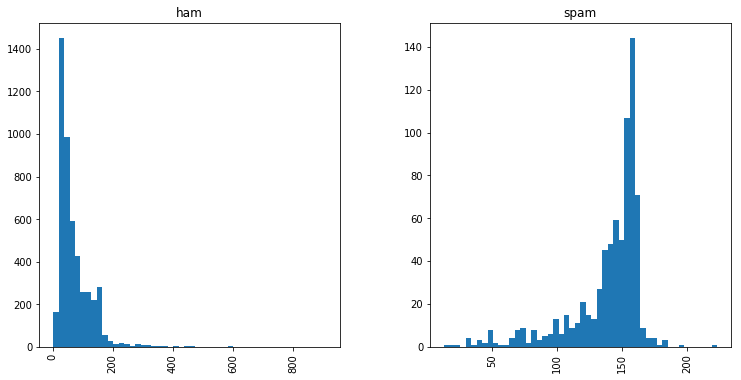

In [20]:
messages.hist(column='length', by="labels", bins=50, figsize=(12,6))

In [21]:
import string

In [22]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
mess = "Sample Message! Notice: it has punctuation"

In [24]:
nopunc = [char for char in mess if char not in string.punctuation]

In [27]:
nopunc = "".join(nopunc)
nopunc

'Sample Message Notice it has punctuation'

In [28]:
from nltk.corpus import stopwords

In [31]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
nopunc.split()

['Sample', 'Message', 'Notice', 'it', 'has', 'punctuation']

In [33]:
clean_mess = [word for word in nopunc.split() if word not in stopwords.words('english')]

In [34]:
clean_mess

['Sample', 'Message', 'Notice', 'punctuation']

In [38]:
def text_process(mess):
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = "".join(nopunc)
    return [word for word in nopunc.split() if word not in stopwords.words('english')]

In [39]:
messages['message'].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, I, dont, think, goes, usf, lives, around...
Name: message, dtype: object

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
bow_transformer = CountVectorizer(analyzer=text_process)

In [72]:
bow_transformer.fit(messages['message'])

CountVectorizer(analyzer=<function text_process at 0x000001775E8BE9D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [81]:
print(len(bow_transformer.vocabulary_))

11617


In [82]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [83]:
bow4 = bow_transformer.transform([message4])

In [84]:
print(bow4)
print(bow4.shape)

  (0, 4221)	2
  (0, 4821)	1
  (0, 5453)	1
  (0, 6396)	1
  (0, 6414)	1
  (0, 7378)	1
  (0, 9746)	2
(1, 11617)


In [85]:
messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

Shape of Sparse Matrix:  (5572, 11617)
Amount of Non-Zero occurences:  56024
sparsity: 0.09%


In [86]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [87]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9746)	0.5385626262927564
  (0, 7378)	0.4389365653379857
  (0, 6414)	0.3187216892949149
  (0, 6396)	0.29953799723697416
  (0, 5453)	0.29729957405868723
  (0, 4821)	0.26619801906087187
  (0, 4221)	0.40832589933384067


In [91]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [93]:
messages_idf = tfidf_transformer.transform(messages_bow)
print(messages_idf.shape)

(5572, 11617)


In [94]:
from sklearn.naive_bayes import MultinomialNB

In [95]:
spam_detect_model = MultinomialNB().fit(messages_idf, messages['labels'])

In [96]:
print("Predicted: ", spam_detect_model.predict(tfidf4)[0])
print("Expected: ", messages['labels'][3])

Predicted:  ham
Expected:  ham


In [98]:
all_predictions = spam_detect_model.predict(messages_idf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [99]:
from sklearn.metrics import classification_report

In [101]:
print(classification_report(messages['labels'],all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.84      0.92       747

   micro avg       0.98      0.98      0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [102]:
from sklearn.model_selection import train_test_split

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(messages['message'], messages['labels'],test_size=0.2)

In [106]:
from sklearn.pipeline import Pipeline

In [107]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)), # strings to token integer counts)
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores) 
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [108]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001775E8BE9D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [110]:
predict = pipeline.predict(X_test)

In [111]:
print(classification_report(predict, Y_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1012
        spam       0.70      1.00      0.82       103

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

